In [22]:
import numpy as np
import sys
sys.path.append('../wofs_phi')
import config as c
import utilities
from sklearn.metrics import brier_score_loss as BS
import os
from shutil import copy
import shutil
import copy
import matplotlib.pyplot as plt
import math
import pandas as pd
import matplotlib.ticker as ticker
import datetime as dt
#from wofs_phi import MLTrainer as t
#from wofs_phi import Grid
#import imageio.v3 as iio
#import skexplain
from copy import deepcopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import pickle
from matplotlib import rc, font_manager
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from wofs.common.zarr import open_dataset
import matplotlib.colors as mpl_colors
import netCDF4 as ncdf
import statistics as stat

In [23]:
def save_data(save_dir, save_file, data, filetype):
    '''saves files while ensuring the directory exists'''
        
    sub_dirs = save_dir.split('/')
    full_dir = ''
    for i in range(len(sub_dirs)):
        sub_dir = sub_dirs[i]
        full_dir = full_dir + '/' + sub_dir
        if not os.path.exists(full_dir):
            try:
                os.mkdir(full_dir)
            except:
                continue
        
    if filetype == 'txt':
        np.savetxt('%s/%s' %(save_dir, save_file), data)
    elif filetype == 'npy':
        np.save('%s/%s' %(save_dir, save_file), data)
    elif filetype == 'csv':
        data.to_csv('%s/%s' %(save_dir, save_file))
    elif filetype == 'pkl':
        pkl = open('%s/%s' %(save_dir, save_file), 'wb')
        pickle.dump(data, pkl)
        pkl.close()
    elif filetype == 'dat':
        data = data.astype('float32')
        data.tofile('%s/%s' %(save_dir, save_file))
    elif filetype == 'png':
        data.savefig('%s/%s' %(save_dir, save_file), dpi=300)
    elif filetype == 'nc':
        if os.path.exists('%s/%s' %(save_dir, save_file)):
            os.remove('%s/%s' %(save_dir, save_file))
        data.to_netcdf('%s/%s' %(save_dir, save_file))
    
    return

In [24]:
def get_plot_style(model_type, train_type, ver_type, train_radius, length):
    marker_size = 4
    
    linestyle = '-'
    linewidth = 2
    fcst_freq_linestyle = '--'
    
    if train_type == 'obs' and ver_type == 'obs':
        color = 'b'
        pod_marker = '*'
    if train_type == 'obs' and ver_type == 'warnings':
        color = 'c'
        pod_marker = 'o'
    elif train_type == 'warnings' and ver_type == 'obs':
        color = 'orange'
        pod_marker = 's'
    elif train_type == 'warnings' and ver_type == 'warnings':
        color = 'r'
        pod_marker = 'D'
    #elif train_type == 'obs_and_warnings':
    #    color = 'g'
    
    return color, linewidth, linestyle, fcst_freq_linestyle, pod_marker, marker_size

In [25]:
def get_train_type_label(train_type):
    
    if train_type == 'obs':
        return 'Reports'
    elif train_type == 'obs_and_warnings':
        return 'Reports+Warnings'
    elif train_type == 'warnings':
        return 'Warnings'

In [26]:
def get_model_label(model_type):
    
    arr = model_type.split('_')
    ps_version = arr[0][3]
    torp_flag = arr[1]
    
    model_label = 'PS%s %s TORP' %(ps_version, torp_flag.capitalize())
    
    if ps_version == '0':
        model_label = 'TORP Only'
    elif 'filtered' in model_type:
        model_label = 'PS3 With Filtered TORP'
    elif 'p_only' in model_type:
        model_label = 'PS3 With P-Only TORP'
    
    
    return model_label

In [27]:
def calc_csi_bias_contours():
    srs = np.arange(0.01, 1, 0.01)
    pods = abs(np.arange(-0.99, 0, 0.01))
    mesh_sr, mesh_pod = np.meshgrid(srs, pods)
    csis = (1/mesh_sr) + (1/mesh_pod) - 1
    return mesh_sr, mesh_pod, 1/csis, mesh_pod/mesh_sr

In [28]:
def get_bss_file(model_type, train_type, ver_type, hazard, length, train_radius, ver_radius, CI):
    directory = '/work/ryan.martz/wofs_phi_data/experiments/%s_trained/length_%s/%s' %(train_type, forecast_length, hazard)
    
    bss_fname = '%s_%s_%skm_trained_%s_%skm_verified_%s_%smin_bootstrapped_bss_from_raw_probs_by_lead_time_%s_percent_CI.npy'\
    %(model_type, train_type, train_radius, ver_type, ver_radius, hazard, length, CI)
    
    full_fname = '%s/%s' %(directory, bss_fname)
    return full_fname

In [29]:
def get_reliability_file(model_type, train_type, ver_type, hazard, length, train_radius, ver_radius, lead, CI):
    directory = '/work/ryan.martz/wofs_phi_data/experiments/%s_trained/length_%s/%s' %(train_type, forecast_length, hazard)
    
    rel_fname = '%s_%s_%skm_trained_%s_%skm_verified_%s_%smin_bootstrapped_rel_%s-%smin_%s_percent_CI.npy'\
    %(model_type, train_type, train_radius, ver_type, ver_radius, hazard, length, lead, lead+length, CI)
    
    full_fname = '%s/%s' %(directory, rel_fname)
    return full_fname

In [30]:
def get_pd_file(model_type, train_type, ver_type, hazard, length, train_radius, ver_radius, lead, CI):
    directory = '/work/ryan.martz/wofs_phi_data/experiments/%s_trained/length_%s/%s' %(train_type, forecast_length, hazard)
    
    pd_fname = '%s_%s_%skm_trained_%s_%skm_verified_%s_%smin_bootstrapped_pd_%s-%smin_%s_percent_CI.npy'\
    %(model_type, train_type, train_radius, ver_type, ver_radius, hazard, length, lead, lead+length, CI)
    
    full_fname = '%s/%s' %(directory, pd_fname)
    return full_fname

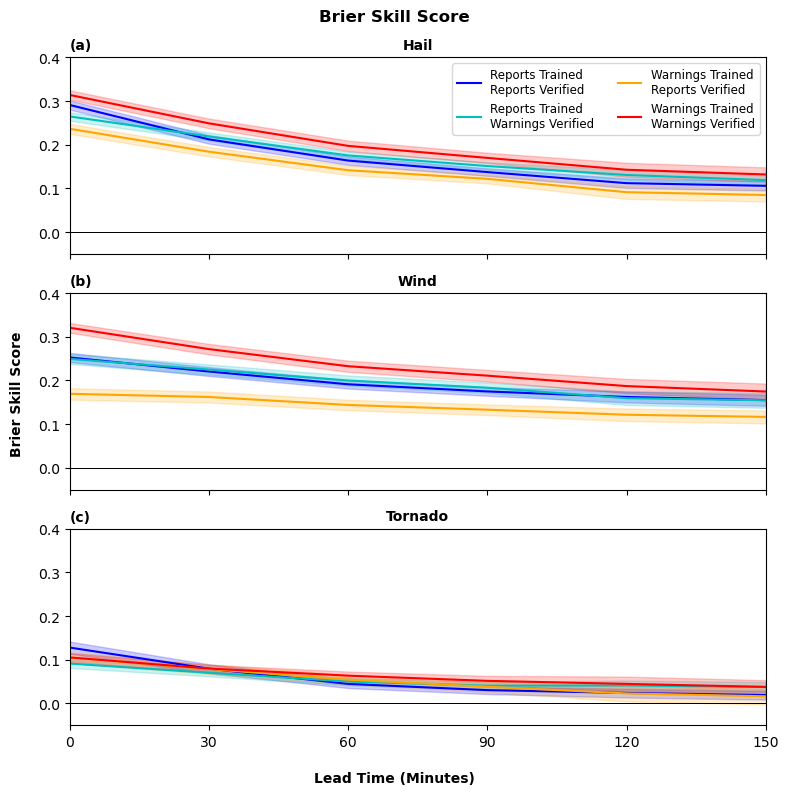

In [20]:
########### BSS Figures ###########

%matplotlib inline

model_type = 'wofs_psv3_with_torp'
hazards = ['hail', 'wind', 'tornado']
train_types = ['obs', 'warnings']
ver_types = ['obs', 'warnings']
match_type = 'all'
CI = 84
forecast_length = 60
#train_radius = 39
#ver_radius = 39
leads = [0, 30, 60, 90, 120, 150]

fill_level = 0.2

fig_save_dir = '/work/ryan.martz/wofs_phi_data/experiments/Paper_Figs/BSS_Plots'
fig, axs = plt.subplots(len(hazards),1,figsize = (8,8))

subplot_labels = ['(a)', '(b)', '(c)']

suptitle = 'Brier Skill Score'

for i in range(len(hazards)):
    hazard = hazards[i]
    
    fig_save_fname = 'all_haz_cross_bss_%s_percent_CI.png' %(CI)

    xticks_font = font_manager.FontProperties(family='DejaVu Sans', style='normal',\
                                              size=10, weight='normal', stretch='normal')
    yticks_font = font_manager.FontProperties(family='DejaVu Sans', style='normal',\
                                              size=10, weight='normal', stretch='normal')
    legend_font = font_manager.FontProperties(family='DejaVu Sans', style='normal',\
                                              size=8.5, weight='normal', stretch='normal')
    
    matched_ver = []
    cross_ver = []
    
    if hazard == 'hail' or hazard == 'tornado':
        train_radius = 39
        ver_radius = 39
    else:
        train_radius = 375
        ver_radius = 375
    
    for train_type in train_types:
        for ver_type in ver_types:
            
            color, linewidth, linestyle, fcst_freq_linestyle, pod_marker, marker_size =\
            get_plot_style(model_type, train_type, ver_type, train_radius, forecast_length)
            
            if train_type == 'obs':
                label_train_type = 'Reports'
            else:
                label_train_type = 'Warnings'
            if ver_type == 'obs':
                label_ver_type = 'Reports'
            else:
                label_ver_type = 'Warnings'
            
            line_label = '%s Trained\n%s Verified' %(label_train_type, label_ver_type)
            
            if hazard == 'hail' or hazard == 'tornado':
                bss_file = get_bss_file(model_type, train_type, ver_type, hazard,\
                                        forecast_length, 39, 39, CI)
            else:
                bss_file = get_bss_file(model_type, train_type, ver_type, hazard,\
                                        forecast_length, 375, 375, CI)
            
            bss = np.load(bss_file)

            axs[i].plot([-30,180], [0,0], 'k', linewidth = 0.5)

            axs[i].fill_between(leads, bss[2,:], y2=bss[0,:], color = color, alpha = fill_level)
            ln = axs[i].plot(leads, bss[1,:], color = color, linestyle = linestyle, label = line_label)
            if train_type == ver_type:
                matched_ver.append(ln)
            else:
                cross_ver.append(ln)
    
    axs[i].set_title(hazard.capitalize(), weight = 'bold', fontsize = 10, fontname="DejaVu Sans")
    axs[i].set_xticks(leads)
    if not (i == 2):
        axs[i].set_xticklabels([])
    axs[i].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
    axs[i].tick_params(axis='both', which='major', labelsize=12)
    axs[i].tick_params(axis='both', which='minor', labelsize=8)
    axs[i].set_ylim([-0.05,0.4])
    axs[i].set_xlim([leads[0], leads[-1]])
    axs[i].spines["top"].set_visible(True)
    axs[i].spines["right"].set_visible(True)
    axs[i].text(0, 1.04, subplot_labels[i], weight = 'bold',\
                fontsize = 10, transform = axs[i].transAxes)
    lns = []
    for l in matched_ver:
        lns += l
    labs = [l.get_label() for l in lns]
    axs[0].legend(lns, labs, prop=legend_font, loc = 'upper right', handlelength=1.5)

    #lns = []
    #for l in cross_ver:
    #    lns += l
    #labs = [l.get_label() for l in lns]
    axs[0].legend(prop=legend_font, loc = 'upper right', ncol = 2)

    for label in axs[i].get_xticklabels():
        label.set_fontproperties(xticks_font)
    for label in axs[i].get_yticklabels():
        label.set_fontproperties(yticks_font)

fig.supxlabel('Lead Time (Minutes)', fontname="DejaVu Sans", fontsize = 10, weight = 'bold')
fig.supylabel('Brier Skill Score', fontname="DejaVu Sans", fontsize = 10, weight = 'bold')
fig.suptitle(suptitle, fontsize = 12, weight = 'bold', fontname="DejaVu Sans")
fig.tight_layout()
save_data(fig_save_dir, fig_save_fname, fig, 'png')

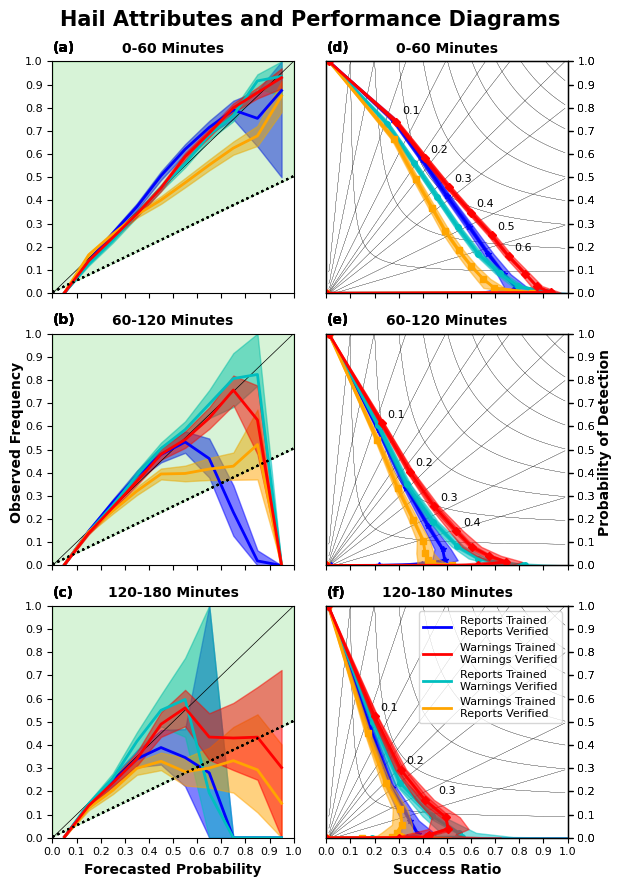

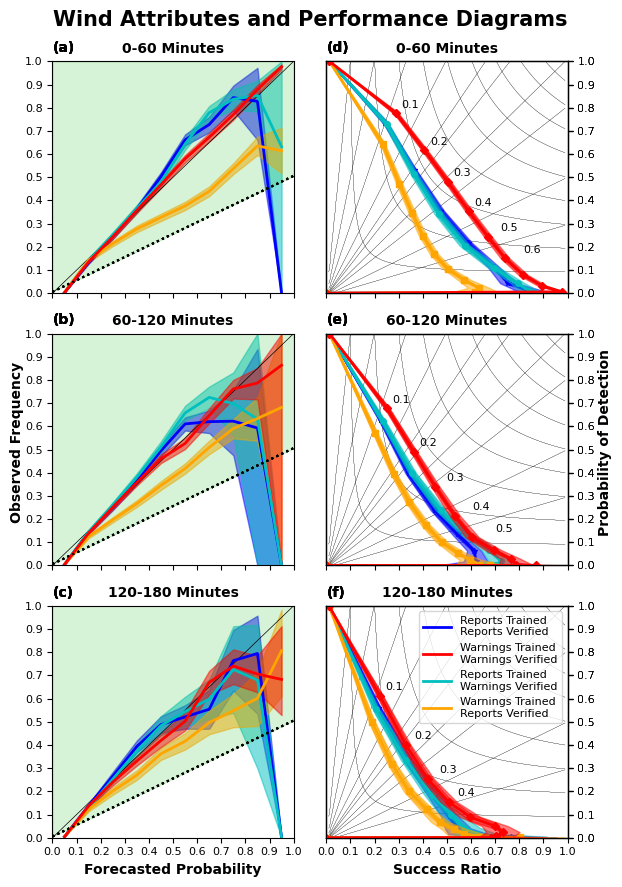

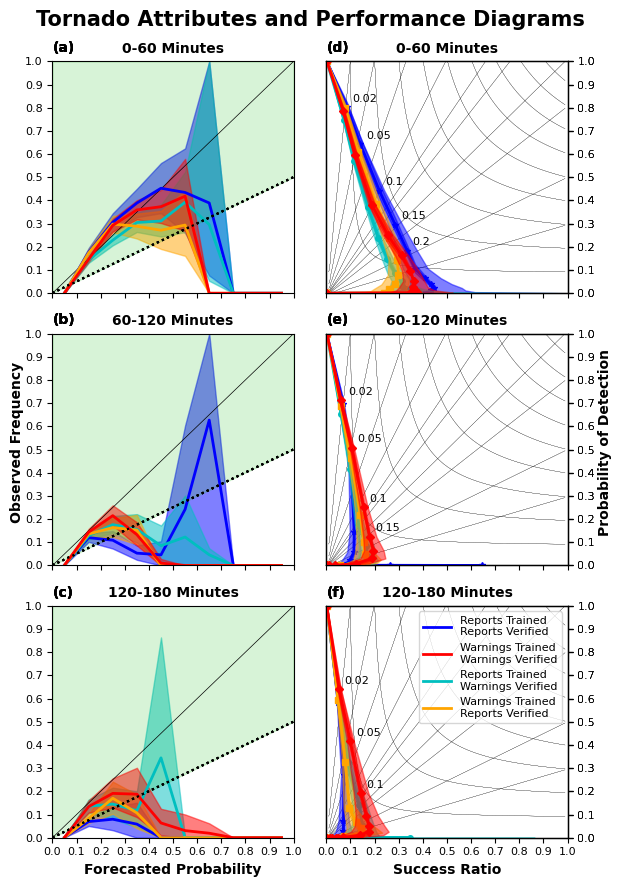

In [31]:
########### Reliability 6 panel subplot ##########

%matplotlib inline
xticks_font = font_manager.FontProperties(family='DejaVu Sans', style='normal',\
                                          size=8, weight='normal', stretch='normal')
yticks_font = font_manager.FontProperties(family='DejaVu Sans', style='normal',\
                                          size=8, weight='normal', stretch='normal')
legend_font = font_manager.FontProperties(family='DejaVu Sans', style='normal',\
                                          size=8, weight='normal', stretch='normal')

model_type = 'wofs_psv3_with_torp'
train_types = ['obs', 'warnings']
ver_types = ['obs', 'warnings']
hazards = ['hail', 'wind', 'tornado']
forecast_length = 60
leads = [30, 90, 150]
CI = 84
#if len(train_types) == 2 and len(ver_types) == 2:
#    matched_ver = True
#else:
#    matched_ver = False

fig_save_dir = '/work/ryan.martz/wofs_phi_data/experiments/Paper_Figs/Rel_PD_Figs'

for hazard in hazards:
    
    if hazard == 'hail' or hazard == 'tornado':
        train_radius = 39
        ver_radius = 39
    else:
        train_radius = 375
        ver_radius = 375
    
    #if matched_ver:
    #    suptitle = 'Respective Verification %s' %(hazard.capitalize())
    #elif len(train_types) == 1:
    #    suptitle = 'Trained: %s %s' %(hazard.capitalize(), get_train_type_label(train_types[0]))
    #elif len(ver_types) == 1:
    #    suptitle = 'Verified: %s %s' %(hazard.capitalize(), get_train_type_label(ver_types[0]))
    
    #if len(leads) == 6:
    fig, axs = plt.subplots(3,2,figsize = (6,9))
    #else:
    #    fig, axs = plt.subplots(2,2,figsize = (6,6))
    
    xticks = np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
    positions_plotted = []
    matched_rel_lns = []
    cross_rel_lns = []
    freq_lns = []
    climo_lns = []
    zero_bss_lns = []
    rel_legend_row = 0
    rel_legend_col = 0
    
    fig_save_fname = '%s_rel_pd_%s_percent_CI.png' %(hazard, CI)
    
    pd_lns = []
    
    plotted_thresholds = np.array([[False, False], [False, False], [False, False]])
    
    max_pods_0 = []
    max_srs_0 = []
    
    max_pods_30 = []
    max_srs_30 = []
    
    max_pods_60 = []
    max_srs_60 = []
    
    max_pods_90 = []
    max_srs_90 = []
    
    max_pods_120 = []
    max_srs_120 = []
    
    max_pods_150 = []
    max_srs_150 = []

    for train_type in train_types:
        for ver_type in ver_types:
            
            if train_type == 'obs':
                label_train_type = 'Reports'
            else:
                label_train_type = 'Warnings'
            if ver_type == 'obs':
                label_ver_type = 'Reports'
            else:
                label_ver_type = 'Warnings'
            
            line_label = '%s Trained\n%s Verified' %(label_train_type, label_ver_type)
            
            ver_radius = train_radius

            rel_scores_lower = []
            rel_scores = []
            rel_scores_upper = []
            climos_lower = []
            climos = []
            climos_upper = []
            
            if train_type == 'obs':
                label_train_type = 'Reports'
            else:
                label_train_type = 'Warnings'
            if ver_type == 'obs':
                label_ver_type = 'Reports'
            else:
                label_ver_type = 'Warnings'
            
            freq_label = '%s %s\nForecast Frequency' %(hazard.capitalize(), get_train_type_label(train_type))
            climo_label = '%s %s\nClimatology' %(hazard.capitalize(), get_train_type_label(ver_type))
            zero_bss_label = '%s %s\nZero BSS' %(hazard.capitalize(), get_train_type_label(ver_type))
            rel_line_label = '%s Trained\n%s Verified' %(label_train_type, label_ver_type)

            for i in range(len(leads)):
                subplot_labels = ['(a)', '(b)', '(c)']
                lead = leads[i]
                row_index = i
                col_index = 0

                if lead+forecast_length > 240:
                    continue

                color, linewidth, linestyle, fcst_freq_linestyle, pod_marker, marker_size =\
                get_plot_style(model_type, train_type, ver_type, train_radius, forecast_length)


                ########################################################################

                rel_data_fname = get_reliability_file(model_type, train_type, ver_type, hazard,\
                                                      forecast_length, train_radius, ver_radius, lead, CI)

                '''Documentation on Reliability Summary Files (Content by Row):
                1. Reliability Score from SR forecasts (2.5, mean, 97.5)
                2. Reliability Score from raw prob forecasts (2.5, mean, 97.5)
                3. Overall climo of forecasted event (2.5, mean, 97.5)
                4. The point forecasts to use for plotting (ex: 0.05, 0.15, 0.25, etc. for 0-0.1, 0.1-0.2, 0.2-0.3, etc.
                5. The event climatology given such a forecast from the SRs (2.5)
                6. The event climatology given such a forecast from the SRs (mean)
                7. The event climatology given such a forecast from the SRs (97.5)
                8. The frequency of forecasts in each range for SR probs (2.5)
                9. The frequency of forecasts in each range for SR probs (mean)
                10. The frequency of forecasts in each range for SR probs (97.5)
                11. The event climatology given such a forecast from the raw probs (2.5)
                12. The event climatology given such a forecast from the raw probs (mean)
                13. The event climatology given such a forecast from the raw probs (97.5)
                14. The frequency of forecasts in each range for raw probs (2.5)
                15. The frequency of forecasts in each range for raw probs (mean)
                16. The frequency of forecasts in each range for raw probs (97.5)'''

                rel_data = np.load(rel_data_fname)

                rel_scores_lower.append(rel_data[1,0])
                rel_scores.append(rel_data[1,1])
                rel_scores_upper.append(rel_data[1,2])

                climos_lower.append(rel_data[2,0])
                climos.append(rel_data[2,1])
                climos_upper.append(rel_data[2,2])

                fcsts = rel_data[3,:]

                fcst_freq_lower = rel_data[13,:]
                fcst_freq = rel_data[14,:]
                fcst_freq_upper = rel_data[15,:]

                obs_freq_lower = rel_data[10,:]
                obs_freq = rel_data[11,:]
                obs_freq_upper = rel_data[12,:]

                if not ((row_index, col_index) in positions_plotted):
                    a = axs[row_index, col_index].plot([0,1], [0,1], 'k', linewidth = 0.5)#, label = 'Perfect Reliability')
                    positions_plotted.append((row_index, col_index))

                b = axs[row_index, col_index].plot(fcsts, obs_freq, color=color, linewidth = linewidth,\
                                                   linestyle = linestyle, label = rel_line_label)
                axs[row_index, col_index].fill_between(fcsts, obs_freq_lower, y2 = obs_freq_upper,\
                                                       color = color, alpha = 0.5)
                if (row_index == rel_legend_row) and (i == 0):
                    if train_type == ver_type:
                        matched_rel_lns.append(b)
                    else:
                        cross_rel_lns.append(b)
                
                #d = axs[row_index, col_index].plot([0,1], [climos[i], climos[i]], color = color,\
                #                                   linewidth = 2)#, label = climo_label)
                #if (row_index == rel_legend_row) and (i == 0):
                #    climo_lns.append(d)
                zero_bss_fcsts = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
                zero_bss = np.zeros(len(zero_bss_fcsts))
                for k in range(len(zero_bss_fcsts)):
                    zero_bss[k] = (zero_bss_fcsts[k] + climos[i])/2
                e = axs[row_index, col_index].plot(zero_bss_fcsts, zero_bss, color = 'k',\
                                                   linestyle = ':')#, label = zero_bss_label)
                axs[row_index, col_index].fill_between(zero_bss_fcsts, zero_bss, y2 = 1,\
                                                       color = 'limegreen', alpha = 0.05)
                if (row_index == rel_legend_row) and (i == 0):
                    zero_bss_lns.append(e)

                for label in axs[row_index, col_index].get_xticklabels():
                    label.set_fontproperties(xticks_font)
                for label in axs[row_index, col_index].get_yticklabels():
                    label.set_fontproperties(yticks_font)
                if row_index < 2:
                    for xlabel_i in axs[row_index, col_index].get_xticklabels():
                        xlabel_i.set_visible(False)

                axs[row_index, col_index].set_title('%s-%s Minutes' %(lead-30, forecast_length+lead-30), fontname="DejaVu Sans", fontsize = 10, weight = 'bold')
                axs[row_index, col_index].set_xlim([0,1])
                axs[row_index, col_index].set_ylim([0,1])
                axs[row_index, col_index].set_xticks(np.arange(0,1.01,0.1))
                axs[row_index, col_index].set_yticks(np.arange(0,1.01,0.1))
                axs[row_index, col_index].spines["top"].set_visible(True)
                axs[row_index, col_index].spines["right"].set_visible(True)
                axs[row_index, col_index].text(0, 1.04, subplot_labels[i], weight = 'bold', fontsize = 10)
                
                ################################### PD Data #####################################
                
                col_index = 1
                subplot_labels = ['(d)', '(e)', '(f)']
                
                pd_ax = axs[row_index, 1].twinx()
                
                pd_fname = get_pd_file(model_type, train_type, ver_type, hazard,\
                                                        forecast_length, train_radius, ver_radius,\
                                                        lead, CI)
                pd_data = np.load(pd_fname)

                '''Documentation on PD Summary Files (Content by Row):
                1. The point thresholds to use for plotting (ex: 0.05, 0.15, 0.25)
                2. The POD for each threshold for SR forecasts (2.5)
                3. The POD for each threshold for SR forecasts (mean)
                4. The POD for each threshold for SR forecasts (97.5)
                5. The SR for each threshold for SR forecasts (2.5)
                6. The SR for each threshold for SR forecasts (mean)
                7. The SR for each threshold for SR forecasts (97.5)
                8. The POD for each threshold for prob forecasts (2.5)
                9. The POD for each threshold for prob forecasts (mean)
                10. The POD for each threshold for prob forecasts (97.5)
                11. The SR for each threshold for prob forecasts (2.5)
                12. The SR for each threshold for prob forecasts (mean)
                13. The SR for each threshold for prob forecasts (97.5)'''

                thresholds = pd_data[0,:]

                pods_lower = pd_data[7,:]
                pods = pd_data[8,:]
                pods_upper = pd_data[9,:]

                srs_lower = pd_data[10,:]
                srs = pd_data[11,:]
                srs_upper = pd_data[12,:]
                
                if i == 0:
                    if len(max_pods_0) == 0:
                        max_pods_0 = pods
                        max_srs_0 = srs
                    else:
                        for j in range(len(max_pods_0)):
                            if pods[j] > max_pods_0[j]:
                                max_pods_0[j] = pods[j]
                            if srs[j] > max_srs_0[j]:
                                max_srs_0[j] = srs[j]
                elif i == 1:
                    if len(max_pods_60) == 0:
                        max_pods_60 = pods
                        max_srs_60 = srs
                    else:
                        for j in range(len(max_pods_60)):
                            if pods[j] > max_pods_60[j]:
                                max_pods_60[j] = pods[j]
                            if srs[j] > max_srs_60[j]:
                                max_srs_60[j] = srs[j]
                elif i == 2:
                    if len(max_pods_120) == 0:
                        max_pods_120 = pods
                        max_srs_120 = srs
                    else:
                        for j in range(len(max_pods_120)):
                            if pods[j] > max_pods_120[j]:
                                max_pods_120[j] = pods[j]
                            if srs[j] > max_srs_120[j]:
                                max_srs_120[j] = srs[j]
                
                mesh_sr, mesh_pod, csis, bias = calc_csi_bias_contours()

                pd = pd_ax.plot(srs, pods, color = color,\
                                                    linewidth = linewidth, linestyle = linestyle,\
                                                    marker = pod_marker, markersize = marker_size,\
                                                    label = line_label)
                pd_ax.fill_between(srs, pods_lower, y2 = pods_upper, color = color, alpha = 0.5)
                pd_ax.fill_betweenx(pods, srs_lower, x2 = srs_upper, color = color, alpha = 0.5)
                
                if i == 0:
                    pd_lns.append(pd)

                csi_lines = axs[row_index, col_index].contour(mesh_sr, mesh_pod, csis, np.arange(0.1, 1, 0.1),\
                                                              colors = ['k'], linewidths = 0.07)
                bias_lines = axs[row_index, col_index].contour(mesh_sr, mesh_pod, bias,\
                                                               [0.3, 0.5, 0.8, 1, 1.3, 1.5, 2, 3, 5, 10],\
                                                               colors = ['k'], linewidths = 0.07)
                
                if train_type == train_types[len(train_types)-1] and ver_type == ver_types[len(ver_types)-1]:
                    if i == 0:
                        max_pods = max_pods_0
                        max_srs = max_srs_0
                    if i == 1:
                        max_pods = max_pods_60
                        max_srs = max_srs_60
                    if i == 2:
                        max_pods = max_pods_120
                        max_srs = max_srs_120
                    for j in range(len(thresholds)):
                        if (pods[j] < 0.1) or (thresholds[j] == 0):
                            continue
                        if hazard == 'tornado':
                            text_label = str(round(thresholds[j], 2))
                        else:
                            text_label = str(round(thresholds[j], 1))
                        pd_ax.annotate(text_label, xy=(max_srs[j], max_pods[j]),\
                                                            xytext = (4,4), textcoords='offset points',\
                                                            fontsize = 8)
                        plotted_thresholds[row_index, col_index] = True

                h2,_ = csi_lines.legend_elements()
                h3,_ = bias_lines.legend_elements()
                axs[row_index, col_index].set_title('%s-%s Minutes' %(lead-30, forecast_length+lead-30), fontname="DejaVu Sans", fontsize = 10, weight = 'bold')
                pd_ax.set_xlim([0,1])
                pd_ax.set_ylim([0,1])
                pd_ax.spines["top"].set_visible(True)
                pd_ax.spines["right"].set_visible(True)
                pd_ax.set_xticks(np.arange(0,1.01,0.1))
                pd_ax.set_yticks(np.arange(0,1.01,0.1))
                pd_ax.text(0, 1.04, subplot_labels[i], weight = 'bold', fontsize = 10)
                
                for ylabel_i in axs[row_index, 1].get_yticklabels():
                    ylabel_i.set_visible(False)
                if row_index < 2:
                    for xlabel_i in axs[row_index, 1].get_xticklabels():
                        xlabel_i.set_visible(False)
                else:
                    for label in axs[2,1].get_xticklabels():
                        label.set_fontproperties(xticks_font)
                axs[0, 1].tick_params(axis='y', length=0)
                axs[1, 1].tick_params(axis='y', length=0)
                axs[2, 1].tick_params(axis='y', length=0)

                #if col_index == 1:
                #    for ylabel_i in pd_ax.get_yticklabels():
                #        ylabel_i.set_visible(False)
                
                for label in pd_ax.get_yticklabels():
                    label.set_fontproperties(yticks_font)
                    label.set_fontweight('light')
    
    lns = []
    for l in matched_rel_lns:
        lns += l
        labs = [l.get_label() for l in lns]
    #axs[0, 0].legend(lns, labs, prop=legend_font, loc = 'upper left', handlelength=2.5)
    
    #lns = []
    for l in cross_rel_lns:
        lns += l
        labs = [l.get_label() for l in lns]
    leg = axs[2, 1].legend(lns, labs, prop=legend_font, loc = 'upper right',\
                     handlelength=2.5, facecolor=(1, 1, 1, 1))
    
    axs[2,0].set_xlabel('Forecasted Probability', fontname="DejaVu Sans", fontsize = 10, weight = 'bold')
    axs[2,1].set_xlabel('Success Ratio', fontname="DejaVu Sans", fontsize = 10, weight = 'bold')
    #fig.supylabel('Observed Probability', fontname="DejaVu Sans", fontsize = 10, weight = 'bold')
    fig.suptitle('%s Attributes and Performance Diagrams'\
                 %(hazard.capitalize()), fontname="DejaVu Sans", fontsize = 15, weight = 'bold')
    fig.tight_layout()
    fig.text(0, 0.5, 'Observed Frequency', fontname="DejaVu Sans",\
             fontsize = 10, va='center', rotation='vertical', weight = 'bold')
    fig.text(0.98, 0.5, 'Probability of Detection', fontname="DejaVu Sans",\
             fontsize = 10, va='center', rotation='vertical', weight = 'bold')
    
    save_data(fig_save_dir, fig_save_fname, fig, 'png')